## Image Pipeline & Preprocessing

WEEK 1: IMAGE PIPELINE & PREPROCESSING
VisionSpec QC - PCB Defect Detection

[Step 1] Initializing Image Pipeline...
✓ Image Pipeline initialized
  - Image size: (224, 224)
  - Batch size: 32

[Step 2] Creating Augmentation Generator...
✓ Augmentation generator created
  - Rotation: ±20°
  - Shift: 20%
  - Brightness: 80-120%
  - Zoom: ±15%
  - Flips: Horizontal & Vertical
✓ Augmentation generator created
  - Rotation: ±20°
  - Shift: 20%
  - Brightness: 80-120%
  - Zoom: ±15%
  - Flips: Horizontal & Vertical
Found 7683 images belonging to 2 classes.
Found 1919 images belonging to 2 classes.

✓ Datasets created from: C:\Users\Pre-Installed User\Downloads\PCBData
  - Training samples: 7683
  - Validation samples: 1919
  - Classes: {'test': 0, 'train': 1}

[Step 4] Visualizing Training Batch...


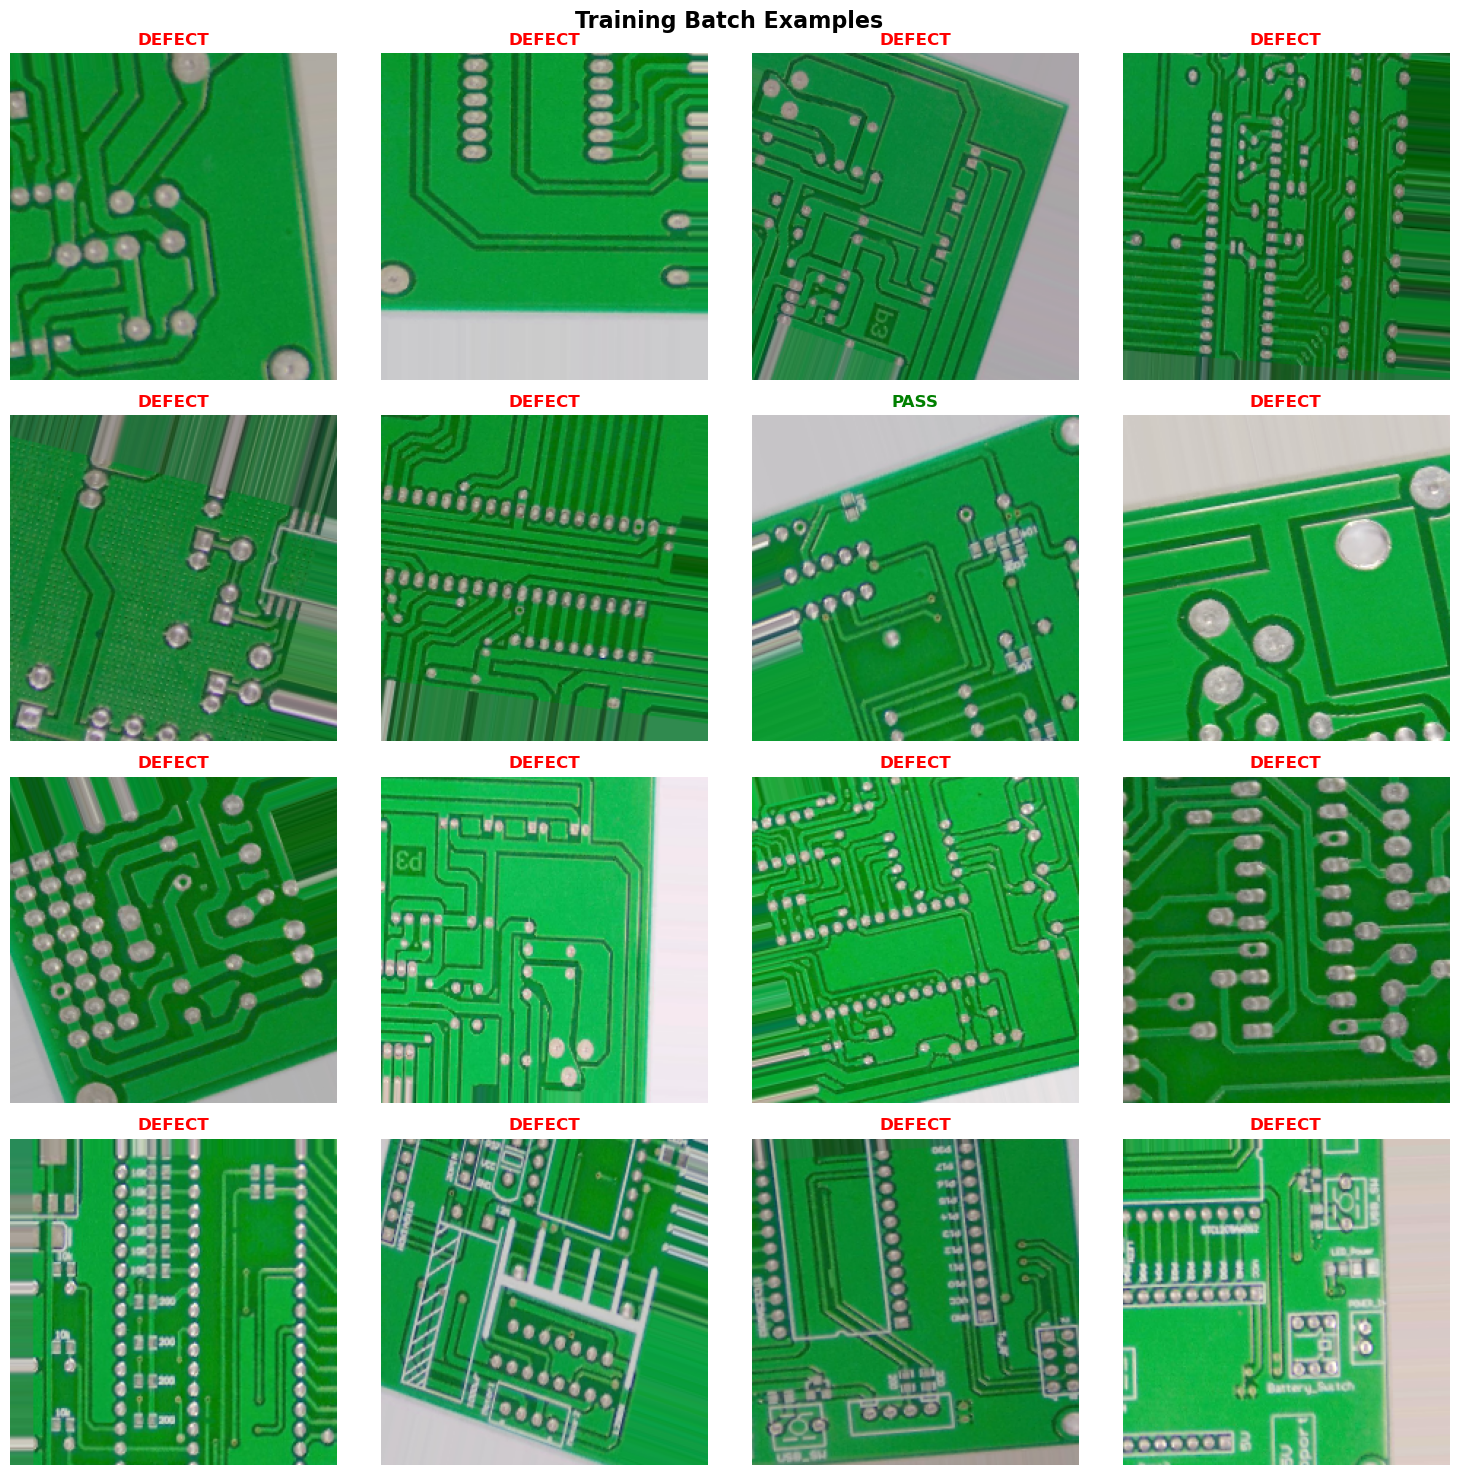

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import os


class ImagePipeline:
    """
    Complete image processing pipeline for PCB defect detection
    Handles loading, preprocessing, and augmentation
    """
    
    def __init__(self, img_size=(224, 224), batch_size=32):
        """
        Initialize image pipeline
        
        Args:
            img_size: Target image dimensions (height, width)
            batch_size: Number of images per batch
        """
        self.img_size = img_size
        self.batch_size = batch_size
        print(f"✓ Image Pipeline initialized")
        print(f"  - Image size: {img_size}")
        print(f"  - Batch size: {batch_size}")
    
    
    def create_augmentation_generator(self):
        """
        Create ImageDataGenerator with comprehensive augmentation
        
        Augmentations applied:
        - Rotation: ±20 degrees
        - Width/Height shift: 20%
        - Brightness: 80-120%
        - Zoom: ±15%
        - Horizontal and vertical flips
        
        Returns:
            ImageDataGenerator object
        """
        datagen = ImageDataGenerator(
            # Geometric transformations
            rotation_range=20,              # Rotate ±20 degrees
            width_shift_range=0.2,          # Shift horizontally 20%
            height_shift_range=0.2,         # Shift vertically 20%
            zoom_range=0.15,                # Zoom in/out 15%
            horizontal_flip=True,           # Random horizontal flip
            vertical_flip=True,             # Random vertical flip
            
            # Lighting transformations
            brightness_range=[0.8, 1.2],    # 80-120% brightness
            
            # Preprocessing
            fill_mode='nearest',            # Fill empty pixels
            rescale=1./255,                 # Normalize to [0, 1]
            validation_split=0.2            # 80-20 train-val split
        )
        
        print("✓ Augmentation generator created")
        print("  - Rotation: ±20°")
        print("  - Shift: 20%")
        print("  - Brightness: 80-120%")
        print("  - Zoom: ±15%")
        print("  - Flips: Horizontal & Vertical")
        
        return datagen
    
    
    def load_and_preprocess_image(self, img_path):
        
        # Load image
        img = cv2.imread(str(img_path))
        
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")
        
        # Convert BGR to RGB (OpenCV loads as BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img = cv2.resize(img, self.img_size)
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
    
    
    def create_dataset_from_directory(self, data_dir, validation_split=0.2):
        
        datagen = self.create_augmentation_generator()
        
        # Training generator (with augmentation)
        train_generator = datagen.flow_from_directory(
            directory=data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',        # Binary: pass=0, defect=1
            subset='training',
            shuffle=True,
            seed=42
        )
        
        # Validation generator (no augmentation, only rescaling)
        val_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split
        )
        
        validation_generator = val_datagen.flow_from_directory(
            directory=data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation',
            shuffle=False,
            seed=42
        )
        
        print(f"\n✓ Datasets created from: {data_dir}")
        print(f"  - Training samples: {train_generator.samples}")
        print(f"  - Validation samples: {validation_generator.samples}")
        print(f"  - Classes: {train_generator.class_indices}")
        
        return train_generator, validation_generator
    
    
    def visualize_augmentations(self, img_path, num_augmentations=9):
        
        # Load original image
        img = self.load_and_preprocess_image(img_path)
        original_img = img.copy()
        
        # Create augmentation generator
        datagen = self.create_augmentation_generator()
        
        # Prepare image for augmentation (add batch dimension)
        img = np.expand_dims(img, axis=0)
        
        # Create figure
        rows = int(np.sqrt(num_augmentations + 1))
        cols = int(np.ceil((num_augmentations + 1) / rows))
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
        axes = axes.flatten()
        
        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Generate and show augmented versions
        aug_iter = datagen.flow(img * 255, batch_size=1)  # Multiply back for datagen
        
        for i in range(1, num_augmentations + 1):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            axes[i].imshow(aug_img)
            axes[i].set_title(f'Augmented {i}', fontsize=10)
            axes[i].axis('off')
        
        # Hide extra subplots
        for i in range(num_augmentations + 1, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Displayed {num_augmentations} augmented versions")


def visualize_batch(generator, num_images=16):
    """
    Visualize a batch of images from generator
    
    Args:
        generator: Data generator
        num_images: Number of images to display
    """
    # Get a batch
    images, labels = next(generator)
    
    # Determine grid size
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        label = 'DEFECT' if labels[i] == 1 else 'PASS'
        color = 'red' if labels[i] == 1 else 'green'
        axes[i].set_title(label, fontsize=12, fontweight='bold', color=color)
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Training Batch Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
def main():
    "Week 1 main demonstration"
    
    print("=" * 70)
    print("WEEK 1: IMAGE PIPELINE & PREPROCESSING")
    print("VisionSpec QC - PCB Defect Detection")
    print("=" * 70)
    
    # Initialize pipeline
    print("\n[Step 1] Initializing Image Pipeline...")
    pipeline = ImagePipeline(img_size=(224, 224), batch_size=32)
    
    # Create augmentation generator
    print("\n[Step 2] Creating Augmentation Generator...")
    datagen = pipeline.create_augmentation_generator()
    
    data_dir = "C:\\Users\\Pre-Installed User\\Downloads\\PCBData"
    
    if os.path.exists(data_dir):
        try:
            train_gen, val_gen = pipeline.create_dataset_from_directory(data_dir)
            
            print("\n[Step 4] Visualizing Training Batch...")
            visualize_batch(train_gen, num_images=16)
            
        except Exception as e:
            print(f"⚠ Could not load dataset: {e}")
            print("\nPlease organize your data as:")
            print("  data/pcb_images/")
            print("    ├── pass/       (defect-free PCB images)")
            print("    └── defect/     (defective PCB images)")
    else:
        print(f"⚠ Data directory not found: {data_dir}")
        print("\nTo use this pipeline:")
        print("1. Create directory structure:")
        print("   data/pcb_images/")
        print("     ├── pass/       (place defect-free PCB images here)")
        print("     └── defect/     (place defective PCB images here)")
        print("2. Run this script again")
    
    # Example: Visualize augmentations on a single image


if __name__ == "__main__":
    main()

## Transfer Learning Model Traning

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import json


class PCBDefectModel:
    """
    Transfer Learning Model for PCB Defect Detection
    Uses pre-trained MobileNetV2 or ResNet50 as base
    """
    
    def __init__(self, img_size=(224, 224), base_model_name='MobileNetV2'):
        """
        Initialize model builder
        
        Args:
            img_size: Input image dimensions (height, width)
            base_model_name: 'MobileNetV2' or 'ResNet50'
        """
        self.img_size = img_size + (3,)  # Add channel dimension
        self.base_model_name = base_model_name
        self.model = None
        self.history = None
        
        print(f"✓ Model Builder initialized")
        print(f"  - Base Model: {base_model_name}")
        print(f"  - Input Shape: {self.img_size}")
    
    
    def build_model(self, freeze_base=True, fine_tune_layers=20):
        """
        Build transfer learning model
        
        Architecture:
        - Pre-trained base model (MobileNetV2/ResNet50)
        - Global Average Pooling
        - Dense layers for classification
        - Dropout for regularization
        
        Args:
            freeze_base: Whether to freeze base model weights
            fine_tune_layers: Number of layers to unfreeze for fine-tuning
            
        Returns:
            Compiled Keras model
        """
        print(f"\n[Building Model...]")
        
        # Load pre-trained base model
        if self.base_model_name == 'MobileNetV2':
            base_model = MobileNetV2(
                input_shape=self.img_size,
                include_top=False,           # Exclude classification head
                weights='imagenet'           # Use ImageNet pre-trained weights
            )
            print(f"✓ Loaded MobileNetV2 (ImageNet weights)")
        
        elif self.base_model_name == 'ResNet50':
            base_model = ResNet50(
                input_shape=self.img_size,
                include_top=False,
                weights='imagenet'
            )
            print(f"✓ Loaded ResNet50 (ImageNet weights)")
        
        else:
            raise ValueError(f"Unknown base model: {self.base_model_name}")
        
        # Freeze/Unfreeze base model
        if freeze_base:
            base_model.trainable = False
            print(f"✓ Base model frozen (transfer learning)")
        else:
            # Freeze all layers except last N
            base_model.trainable = True
            for layer in base_model.layers[:-fine_tune_layers]:
                layer.trainable = False
            print(f"✓ Fine-tuning last {fine_tune_layers} layers")
        
        # Build complete model
        inputs = keras.Input(shape=self.img_size, name='input_image')
        
        # Base model
        x = base_model(inputs, training=False)
        
        # Classification head
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.Dense(256, activation='relu', name='dense_256')(x)
        x = layers.Dropout(0.5, name='dropout_1')(x)
        x = layers.Dense(128, activation='relu', name='dense_128')(x)
        x = layers.Dropout(0.3, name='dropout_2')(x)
        outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
        
        # Create model
        self.model = keras.Model(inputs=inputs, outputs=outputs, name='PCB_Defect_Detector')
        
        # Print model summary
        print(f"\n{'='*70}")
        self.model.summary()
        print(f"{'='*70}\n")
        
        # Count trainable parameters
        trainable_params = sum([tf.size(w).numpy() for w in self.model.trainable_weights])
        total_params = sum([tf.size(w).numpy() for w in self.model.weights])
        
        print(f"✓ Model built successfully")
        print(f"  - Total parameters: {total_params:,}")
        print(f"  - Trainable parameters: {trainable_params:,}")
        print(f"  - Non-trainable parameters: {total_params - trainable_params:,}")
        
        return self.model
    
    
    def compile_model(self, learning_rate=0.001, metrics=None):
        """
        Compile model with optimizer, loss, and metrics
        
        Args:
            learning_rate: Initial learning rate
            metrics: List of metrics to track
        """
        if metrics is None:
            metrics = [
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc')
            ]
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=metrics
        )
        
        print(f"\n✓ Model compiled")
        print(f"  - Optimizer: Adam (lr={learning_rate})")
        print(f"  - Loss: Binary Crossentropy")
        print(f"  - Metrics: {[m if isinstance(m, str) else m.name for m in metrics]}")
    
    
    def create_callbacks(self, model_save_path='best_model.h5'):
        """
        Create training callbacks
        
        Returns:
            List of callbacks
        """
        callbacks = [
            # Early Stopping
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            
            # Reduce Learning Rate
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,              # Reduce LR by half
                patience=3,
                min_lr=1e-7,
                verbose=1
            ),
            
            # Model Checkpoint
            ModelCheckpoint(
                filepath=model_save_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
        
        print(f"✓ Callbacks configured")
        print(f"  - Early Stopping (patience=5)")
        print(f"  - Reduce LR on Plateau (patience=3)")
        print(f"  - Model Checkpoint: {model_save_path}")
        
        return callbacks
    
    
    def train(self, train_generator, validation_generator, 
              epochs=20, callbacks=None, verbose=1):
        """
        Train the model
        
        Args:
            train_generator: Training data generator
            validation_generator: Validation data generator
            epochs: Number of training epochs
            callbacks: List of callbacks (auto-created if None)
            verbose: Verbosity mode
            
        Returns:
            Training history
        """
        if callbacks is None:
            callbacks = self.create_callbacks()
        
        print(f"\n{'='*70}")
        print(f"STARTING TRAINING")
        print(f"{'='*70}")
        print(f"Epochs: {epochs}")
        print(f"Training samples: {train_generator.samples}")
        print(f"Validation samples: {validation_generator.samples}")
        print(f"Batch size: {train_generator.batch_size}")
        print(f"{'='*70}\n")
        
        # Train model
        self.history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=verbose
        )
        
        print(f"\n{'='*70}")
        print(f"TRAINING COMPLETE ✓")
        print(f"{'='*70}\n")
        
        return self.history
    
    
    def plot_training_history(self, save_path=None):
        """
        Plot training and validation metrics
        
        Args:
            save_path: Path to save plot (optional)
        """
        if self.history is None:
            print("⚠ No training history available. Train model first.")
            return
        
        history = self.history.history
        epochs_range = range(1, len(history['loss']) + 1)
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Loss
        axes[0, 0].plot(epochs_range, history['loss'], 'b-', label='Training Loss', linewidth=2)
        axes[0, 0].plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        axes[0, 0].set_title('Loss vs. Epochs', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[0, 1].plot(epochs_range, history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
        axes[0, 1].plot(epochs_range, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
        axes[0, 1].set_title('Accuracy vs. Epochs', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Precision
        if 'precision' in history:
            axes[1, 0].plot(epochs_range, history['precision'], 'b-', label='Training Precision', linewidth=2)
            axes[1, 0].plot(epochs_range, history['val_precision'], 'r-', label='Validation Precision', linewidth=2)
            axes[1, 0].set_title('Precision vs. Epochs', fontsize=14, fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Recall
        if 'recall' in history:
            axes[1, 1].plot(epochs_range, history['recall'], 'b-', label='Training Recall', linewidth=2)
            axes[1, 1].plot(epochs_range, history['val_recall'], 'r-', label='Validation Recall', linewidth=2)
            axes[1, 1].set_title('Recall vs. Epochs', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('Training History - PCB Defect Detection', 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Training history saved to: {save_path}")
        
        plt.show()
    
    
    def evaluate(self, test_generator):
        """
        Evaluate model on test data
        
        Args:
            test_generator: Test data generator
            
        Returns:
            Dictionary of evaluation metrics
        """
        print(f"\n{'='*70}")
        print(f"EVALUATING MODEL")
        print(f"{'='*70}")
        
        results = self.model.evaluate(test_generator, verbose=1)
        
        metrics = {}
        for i, metric_name in enumerate(self.model.metrics_names):
            metrics[metric_name] = results[i]
        
        print(f"\n✓ Evaluation Results:")
        for metric, value in metrics.items():
            print(f"  - {metric.capitalize()}: {value:.4f}")
        
        return metrics
    
    
    def save_model(self, filepath='pcb_defect_model.h5'):
        """Save model to disk"""
        self.model.save(filepath)
        print(f"✓ Model saved to: {filepath}")
    
    
    def load_model(self, filepath):
        """Load model from disk"""
        self.model = keras.models.load_model(filepath)
        print(f"✓ Model loaded from: {filepath}")


# =============================================================================
# MAIN EXECUTION - WEEK 2 DEMONSTRATION
# =============================================================================

def main():
    """Week 2 main demonstration"""
    
    print("=" * 70)
    print("WEEK 2: TRANSFER LEARNING MODEL TRAINING")
    print("VisionSpec QC - PCB Defect Detection")
    print("=" * 70)
    
    # Check GPU availability
    print("\n[Hardware Check]")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✓ GPU available: {len(gpus)} device(s)")
        for gpu in gpus:
            print(f"  - {gpu}")
    else:
        print("⚠ No GPU detected. Training will use CPU (slower)")
    
    # Initialize model
    print("\n[Step 1] Building Model...")
    model_builder = PCBDefectModel(
        img_size=(224, 224),
        base_model_name='MobileNetV2'
    )
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    # Build architecture
    model = model_builder.build_model(freeze_base=True)
    
    # Compile model
    print("\n[Step 2] Compiling Model...")
    model_builder.compile_model(learning_rate=0.001)
    
    # Note: Training requires data generators from Week 1
    print("\n[Step 3] Training Setup...")
    print("⚠ To train the model, you need:")
    print("  1. Data generators from Week 1")
    print("  2. Organized dataset in 'data/pcb_images/' directory")
    print("\nExample training code:")
    print("""
    # Import Week 1 pipeline
    from week1_image_pipeline import ImagePipeline
    
    # Create data generators
    pipeline = ImagePipeline()
    train_gen, val_gen = pipeline.create_dataset_from_directory(
    r"C:\\Users\\Pre-Installed User\\Downloads\\PCBData"
    
    # Train model
    history = model_builder.train(
        train_generator=train_gen,
        validation_generator=val_gen,
        epochs=20
    )
    
    # Plot training history
    model_builder.plot_training_history(save_path='training_history.png')
    
    # Save model
    model_builder.save_model('pcb_defect_model.h5')
    """)
    
    print("\n" + "=" * 70)
    print("WEEK 2 SETUP COMPLETE ✓")
    print("=" * 70)
    print("\nNext Steps:")
    print("  - Train model with your dataset")
    print("  - Analyze learning curves for overfitting/underfitting")
    print("  - Adjust hyperparameters if needed")
    print("  - Proceed to Week 3: Grad-CAM Visualization")


if __name__ == "__main__":
    main()

WEEK 2: TRANSFER LEARNING MODEL TRAINING
VisionSpec QC - PCB Defect Detection

[Hardware Check]
⚠ No GPU detected. Training will use CPU (slower)

[Step 1] Building Model...
✓ Model Builder initialized
  - Base Model: MobileNetV2
  - Input Shape: (224, 224, 3)

[Building Model...]
✓ Loaded MobileNetV2 (ImageNet weights)
✓ Base model frozen (transfer learning)

Model: "PCB_Defect_Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
              

## Grad-CAM Visualization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
DATA_DIR = r"C:\Users\Pre-Installed User\Downloads\PCBData"
MODEL_PATH = r"C:\Users\Pre-Installed User\Downloads\pcb_defect_model.h5"

train_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=(224, 224),
    batch_size=16,
    label_mode="binary"
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=(224, 224),
    batch_size=16,
    label_mode="binary"
)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=test_ds, epochs=5)

model.save(MODEL_PATH)
print("✅ MODEL SAVED AT:", MODEL_PATH)



Found 8534 files belonging to 2 classes.
Found 1068 files belonging to 2 classes.



Epoch 1/5


534/534 [==============================] - 239s 445ms/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 9.8472e-07 - val_accuracy: 1.0000
Epoch 2/5
534/534 [==============================] - 226s 421ms/step - loss: 4.9780e-07 - accuracy: 1.0000 - val_loss: 2.2154e-07 - val_accuracy: 1.0000
Epoch 3/5
534/534 [==============================] - 258s 481ms/step - loss: 1.5328e-07 - accuracy: 1.0000 - val_loss: 9.2175e-08 - val_accuracy: 1.0000
Epoch 4/5
534/534 [==============================] - 285s 534ms/step - loss: 7.1984e-08 - accuracy: 1.0000 - val_loss: 4.8516e-08 - val_accuracy: 1.0000
Epoch 5/5
534/534 [==============================] - 304s 566ms/step - loss: 4.0311e-08 - accuracy: 1.0000 - val_loss: 2.8769e-08 - val_accuracy: 1.0000


C:\Users\Pre-Installed User\anaconda3\envs\vision\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ MODEL SAVED AT: C:\Users\Pre-Installed User\Downloads\pcb_defect_model.h5


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from pathlib import Path
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.models import load_model

MODEL_PATH = r"C:\Users\Pre-Installed User\Downloads\pcb_defect_model.keras"

model = load_model(MODEL_PATH)
print("✅ Model loaded successfully")

CLASS_NAMES = ["defect", "pass"]
IMG_SIZE = (224, 224)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
def predict_single_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0][0]

    label = "pass" if prediction > 0.5 else "defect"
    confidence = prediction if label == "pass" else 1 - prediction

    return {
        "image": img_path,
        "prediction": label,
        "confidence": float(confidence)
    }
def predict_folder(folder_path):
    results = []
    folder_path = Path(folder_path)

    for img_path in folder_path.glob("*.*"):
        if img_path.suffix.lower() in [".jpg", ".png", ".jpeg"]:
            result = predict_single_image(str(img_path))
            results.append(result)

    return results
test_image = r"C:\Users\Pre-Installed User\Downloads\PCBData\test\images\rotation_90_light_12_spur_02_1_600.jpg"
result = predict_single_image(test_image)
print(result)
test_folder = r"C:\Users\Pre-Installed User\Downloads\PCBData\test\image"

results = predict_folder(test_folder)
print("Number of images found:", len(results))

for r in results:
    print(r)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("pcb_defect_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved")


✅ Model loaded successfully
1/1 [==============================] - 0s 90ms/step
{'image': 'C:\\Users\\Pre-Installed User\\Downloads\\PCBData\\test\\images\\rotation_90_light_12_spur_02_1_600.jpg', 'prediction': 'pass', 'confidence': 0.6536768078804016}
Number of images found: 0
INFO:tensorflow:Assets written to: C:\Users\PRE-IN~1\AppData\Local\Temp\tmpc_i5jy7x\assets


INFO:tensorflow:Assets written to: C:\Users\PRE-IN~1\AppData\Local\Temp\tmpc_i5jy7x\assets


✅ TFLite model saved
